# PW5
**Maud TISSOT**

In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

## **LOAD DATA**

In [2]:
def load_reviews_from_directory(directory):
    reviews = []
    labels  = []

    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), "r", encoding="utf-8") as file:
                review = file.read()
                reviews.append(review)
                if directory.endswith("pos/"):
                    labels.append("positive")
                elif directory.endswith("neg/"):
                    labels.append("negative")

    return reviews, labels

In [3]:
from google.colab import drive
drive.mount('/content/dossiers')

path_neg = "/content/dossiers/MyDrive/review_polarity/txt_sentoken/neg/"
path_pos = "/content/dossiers/MyDrive/review_polarity/txt_sentoken/pos/"

positive_reviews, positive_labels = load_reviews_from_directory(path_pos)
negative_reviews, negative_labels = load_reviews_from_directory(path_neg)

all_reviews = positive_reviews + negative_reviews
all_labels = positive_labels + negative_labels

Drive already mounted at /content/dossiers; to attempt to forcibly remount, call drive.mount("/content/dossiers", force_remount=True).


In [4]:
print("Nombre total de critiques          :",len(all_reviews))
print("Nombre total de critiques positives:",len(positive_reviews))
print("Nombre total de critiques negatives:",len(negative_reviews))

Nombre total de critiques          : 2000
Nombre total de critiques positives: 1000
Nombre total de critiques negatives: 1000


In [5]:
print("Positive Review:\n")
print(positive_reviews[10][:500],"etc...")
print("\nLabel:", positive_labels[10])

Positive Review:

after watching " rat race " last week , i noticed my cheeks were sore and realized that , when not laughing aloud , i had held a grin for virtually all of the film's 112 minutes . 
saturday night , i attended another sneak preview for the movie and damned if i didn't enjoy it as much the second time as the first . 
 " rat race " is a great goofy delight , a dandy mix of energetic performances , inspired sight gags and flat-out silliness . 
hands down , this is the most fun film of the summer . 
 etc...

Label: positive


In [6]:
print("Negative Review:\n")
print(negative_reviews[10][:500],"etc...")
print("\nLabel:", negative_labels[10])

Negative Review:

best remembered for his understated performance as dr . hannibal lecter in michael mann's forensics thriller , manhunter , scottish character actor brian cox brings something special to every movie he works on . 
usually playing a bit role in some studio schlock ( he dies halfway through the long kiss goodnight ) , he's only occasionally given something meaty and substantial to do . 
if you want to see some brilliant acting , check out his work as a dogged police inspector opposite frances mcdor etc...

Label: negative


## **PREPARE DATA**

### **- Tokenize**

The Tokenizer class from keras.preprocessing.text in the Keras library is a utility class that is used to vectorize a text corpus into a list of integers.

- fit_on_texts(): takes a list of strings as input and updates the internal vocabulary of the Tokenizer based on the unique words in the input texts.

- texts_to_sequences(texts): This method uses the word index that was created during the fit_on_texts step to convert each word in the texts to its corresponding integer index.

- pad_sequences(sequences, maxlen): This line takes truncates all tokens to have a uniform length. If a sequence is shorter than max_len, it will be padded at the beginning with zeros. If it's longer, it will be truncated.

In [7]:
#https://stackoverflow.com/questions/56880252/using-pre-trained-word-embeddings-in-a-keras-model
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_reviews)
seq = tokenizer.texts_to_sequences(all_reviews)

print("\nBefore Padding\n")
print("Nombre de critiques :", len(seq))
print("Taille du token     :",len(seq[0]),"varie selon la review")
print("type                :",type(seq[0][0]))

print("\nAfter Padding\n")
max_len = 200
seq = pad_sequences(seq, maxlen = max_len)  #pad for deep learning model, inputs must have same dimensions

print("Nombre de critiques :", len(seq))
print("Taille du token     :",len(seq[0]))
print("type                :",type(seq[0][0]))


Before Padding

Nombre de critiques : 2000
Taille du token     : 692 varie selon la review
type                : <class 'int'>

After Padding

Nombre de critiques : 2000
Taille du token     : 200
type                : <class 'numpy.int32'>


### **- Split in train test**

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(seq, all_labels, test_size=0.3, random_state=40)

Y_train = np.where(np.array(Y_train) == 'positive', 1, 0)
Y_test  = np.where(np.array(Y_test)  == 'positive', 1, 0)
X_train = np.array(X_train)
X_test  = np.array(X_test)

print("Train")
print(" - x shape : ",np.shape(X_train))
print(" - y shape : ",np.shape(Y_train))
print("\nTest")
print(" - x shape : ",np.shape(X_test))
print(" - y shape : ",np.shape(Y_test))

Train
 - x shape :  (1400, 200)
 - y shape :  (1400,)

Test
 - x shape :  (600, 200)
 - y shape :  (600,)


## **LOAD GLOVE WORD EMBEDDINGS**

### **- Load model**

- The embeddings_index dictionary will contain word embeddings for words present in the GloVe file.
- Each word is associated with a vector of 50 floating-point values.
- This dictionary is used to retrieve word embeddings for specific words.

In [9]:
#https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python

embedding_dim = 50
embeddings_index = {}
with open('/content/dossiers/MyDrive/glove.6B.50d.txt', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word   = values[0]
        coefs  = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

### **- Create embeddings**

- Create the matrix of embeddings
- Each row corresponds to the word index of a word in your text data
- The values in each row are the pre-trained word embedding vectors obtained from GloVe.
- This matrix is used as an initial embedding layer in a neural network.







In [10]:
#https://stackoverflow.com/questions/56880252/using-pre-trained-word-embeddings-in-a-keras-model
nbWords  = len(tokenizer.word_index) + 1
array    = np.zeros((nbWords, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < nbWords:
        vectors = embeddings_index.get(word)
        if vectors is not None:
            array[i] = vectors

print("nb of words      : ",nbWords)
print("embeddings shape : ",np.shape(array))

nb of words      :  43297
embeddings shape :  (43297, 50)


In [19]:
def tsneViz(embeddings, method, perplexity=30, num_clusters=6):
    tsne = TSNE(n_components=3, random_state=42, perplexity=perplexity)
    embeddings_tsne = tsne.fit_transform(embeddings)
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(embeddings)
    df = pd.DataFrame(embeddings_tsne, columns=['Dim1', 'Dim2', 'Dim3'])
    df['Cluster'] = clusters.astype(str)
    fig = px.scatter_3d(df, x='Dim1', y='Dim2', z='Dim3',
                        color='Cluster', title=f"{method} Embeddings - 3D t-SNE Visualization with Clusters")
    fig.update_traces(marker=dict(size=5))
    fig.show()

tsneViz(array[:200,:],"glove dim=50")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



## **EVALUATE REVIEWS SENTIMENT**

### **- Create model**

In [20]:
random.seed(200)

model = Sequential()
model.add(Embedding(input_dim=nbWords, output_dim=embedding_dim, input_length=max_len,weights=[array], trainable=False))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

### **- Compile with loss, optimizer and metric**

In [21]:
#optimizer = Adam(learning_rate=0.01)
model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])

### **- Train model**

In [22]:
history = model.fit(X_train, Y_train, epochs=40, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/40
44/44 [==============================] - 7s 141ms/step - loss: 0.9562 - accuracy: 0.5079 - val_loss: 0.6922 - val_accuracy: 0.5167
Epoch 2/40
44/44 [==============================] - 4s 86ms/step - loss: 0.7246 - accuracy: 0.5200 - val_loss: 0.6929 - val_accuracy: 0.4917
Epoch 3/40
44/44 [==============================] - 4s 87ms/step - loss: 0.6990 - accuracy: 0.5571 - val_loss: 0.6904 - val_accuracy: 0.5683
Epoch 4/40
44/44 [==============================] - 4s 87ms/step - loss: 0.6921 - accuracy: 0.5550 - val_loss: 0.6884 - val_accuracy: 0.5333
Epoch 5/40
44/44 [==============================] - 5s 120ms/step - loss: 0.6937 - accuracy: 0.5614 - val_loss: 0.6873 - val_accuracy: 0.5400
Epoch 6/40
44/44 [==============================] - 5s 110ms/step - loss: 0.6786 - accuracy: 0.5957 - val_loss: 0.6822 - val_accuracy: 0.5333
Epoch 7/40
44/44 [==============================] - 4s 90ms/step - loss: 0.6101 - accuracy: 0.6693 - val_loss: 0.6467 - val_accuracy: 0.6383
Epoch 8/40

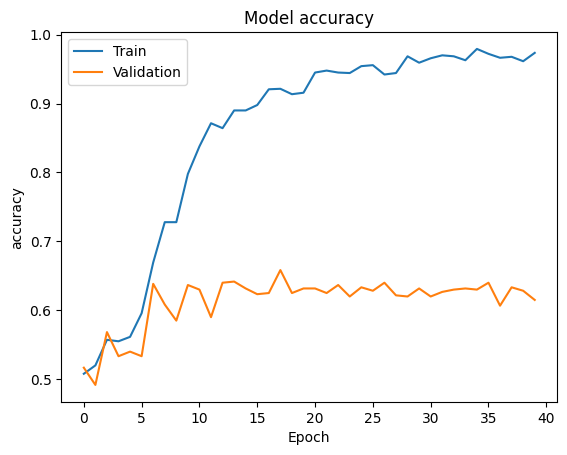

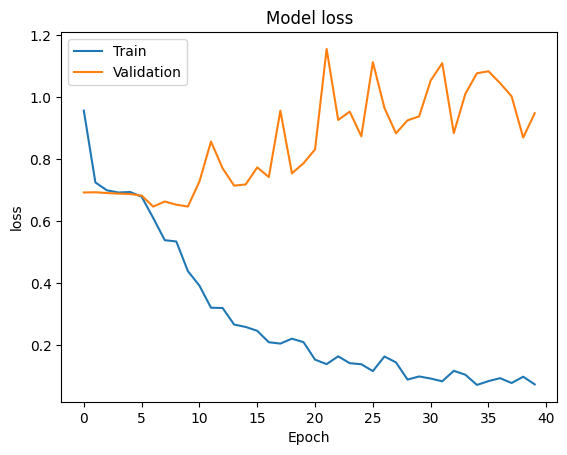

In [23]:
infos = ["accuracy","loss"]
for info in infos:
  plt.plot(history.history[info])
  plt.plot(history.history[f'val_{info}'])
  plt.title(f'Model {info}')
  plt.xlabel('Epoch')
  plt.ylabel(f'{info}')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

### **- Evaluate predictions**

In [25]:
proba  = model.predict(X_test)
y_pred = (proba > 0.5).astype(int)
accuracy = accuracy_score(Y_test, y_pred)
accuracy_positive = accuracy_score(Y_test[Y_test == 1], y_pred[Y_test == 1])
accuracy_negative = accuracy_score(Y_test[Y_test == 0], y_pred[Y_test == 0])
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Accuracy positive reviews: {:.2f}%".format(accuracy_positive * 100))
print("Accuracy negative reviews: {:.2f}%".format(accuracy_negative * 100))

19/19 [==============================] - 0s 23ms/step
Accuracy: 61.50%
Accuracy positive reviews: 61.30%
Accuracy negative reviews: 61.69%


It's the model that has the lowest delat of accuracy between negatif and positives reviews predicitions

choising :
- model
- token len : 200
- glove dim : 50
- learning rate : default
- optimizer : Adam
- batch size : 32


